<a href="https://colab.research.google.com/github/Rohan1511/LearningGit/blob/main/Unet_tr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%env SM_FRAMEWORK=tf.keras

!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [13]:
pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9MB 12.2MB/s 
     |████████████████████████████████| 15.7MB 188kB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras 

#from keras.utils import normalize
#from keras.metrics import MeanIoU



Segmentation Models: using `tf.keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

dset_root = '/content/drive/MyDrive/' # right click and copy 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
x_train_dir = os.path.join(dset_root, '_Train_data3') # saving full path for training
y_train_dir = os.path.join(dset_root, '_Train_labels') # saving full path for training
x_valid_dir = os.path.join(dset_root, '_Val_data') # Path for validation data
y_valid_dir = os.path.join(dset_root, '_validation_labels2') # saving full path for training

In [6]:
#Checking the directory is nor empty and have files. 
print('Train1: {}'.format(len(os.listdir(x_train_dir))))
print('Train1_lab: {}'.format(len(os.listdir(y_train_dir))))
print('Validation: {}'.format(len(os.listdir(x_valid_dir))))
print('Validation_labels: {}'.format(len(os.listdir(y_valid_dir))))

Train1: 33404
Train1_lab: 33404
Validation: 10399
Validation_labels: 10399


In [12]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    #plt.colorbar    
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0','255']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)[0:3000]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


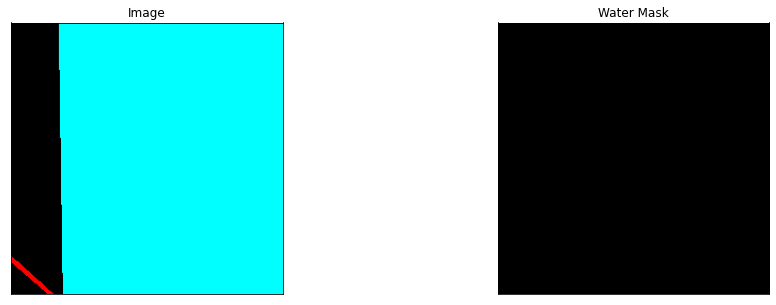

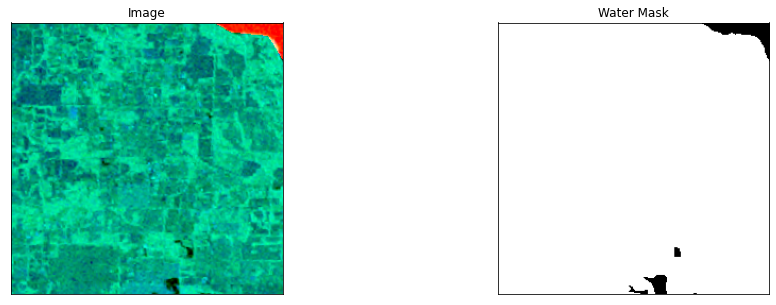

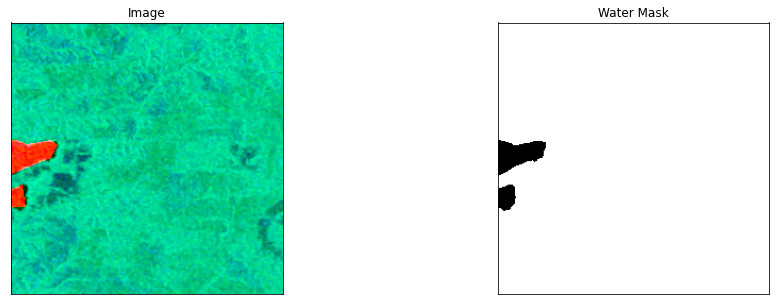

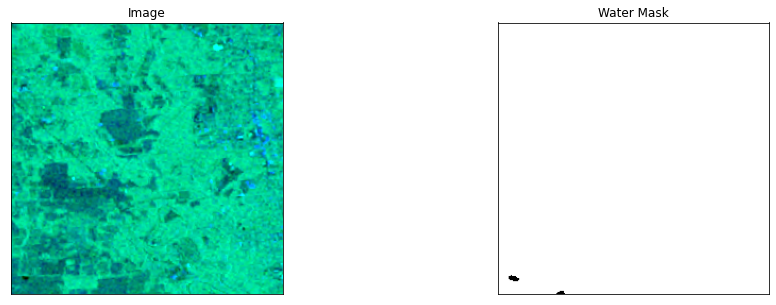

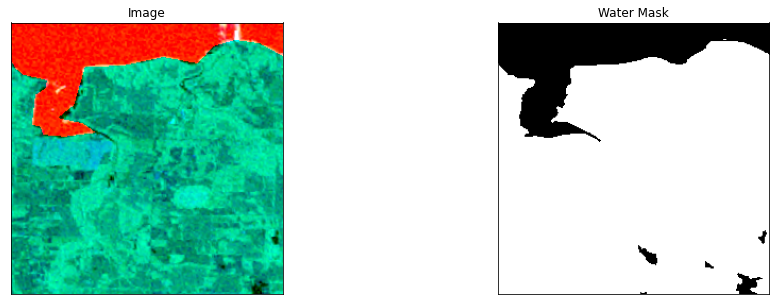

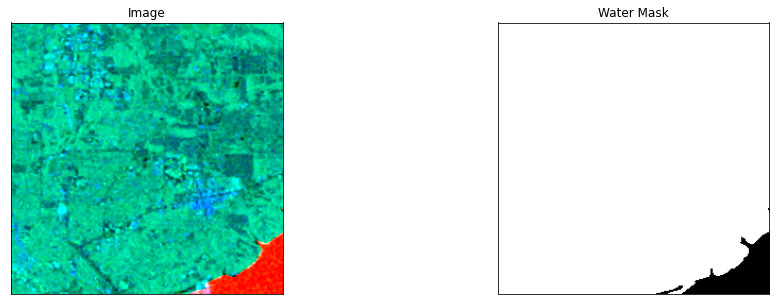

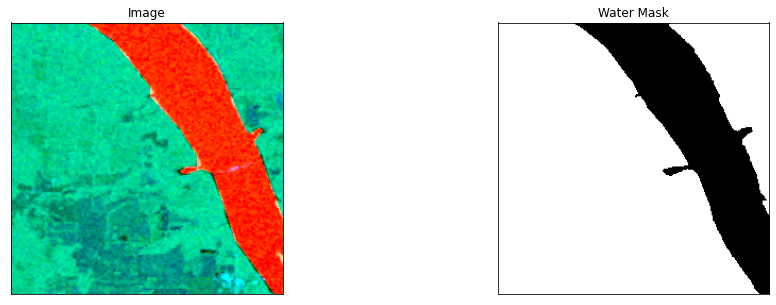

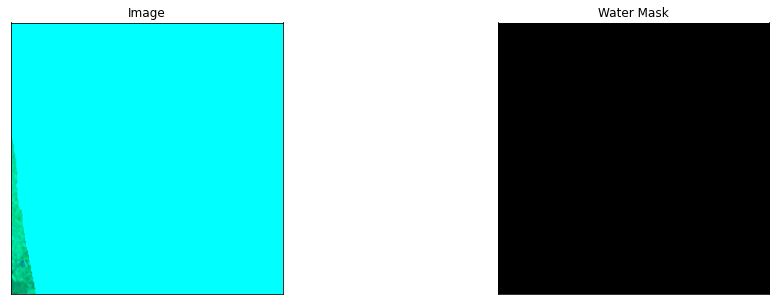

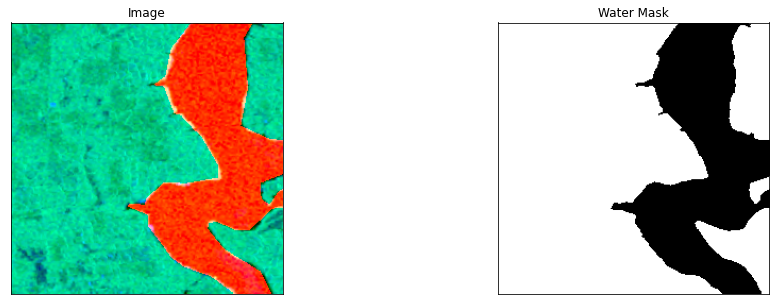

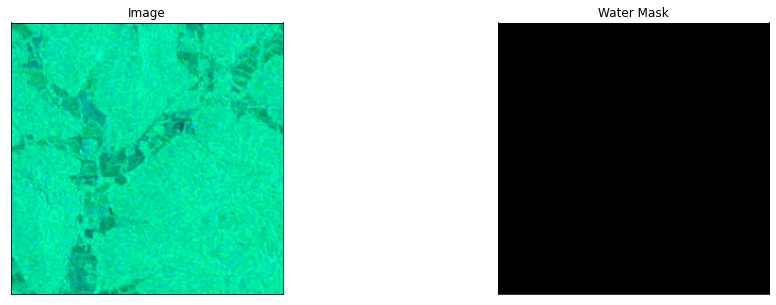

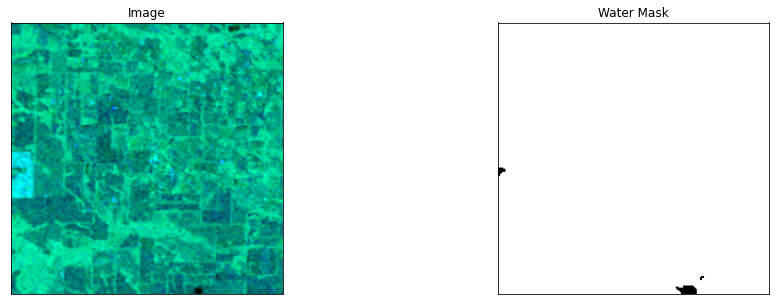

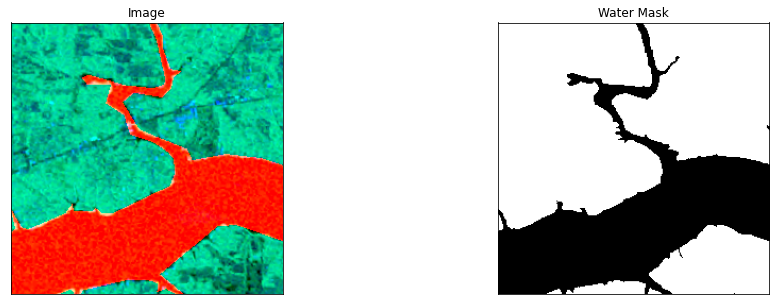

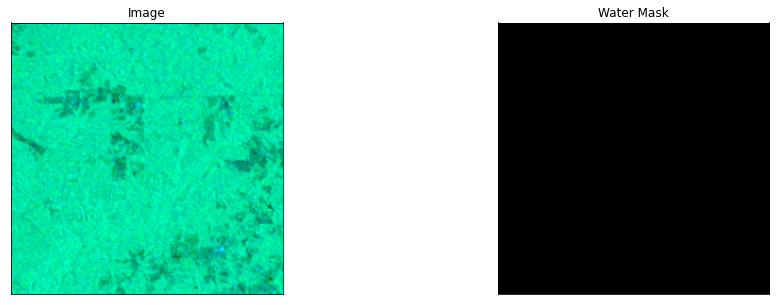

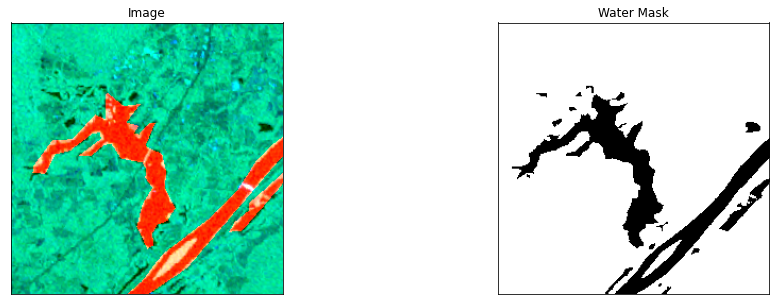

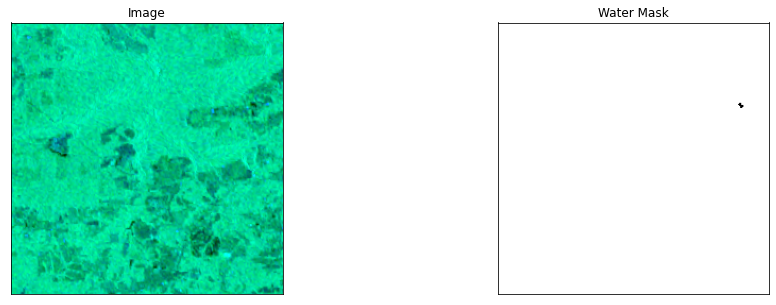

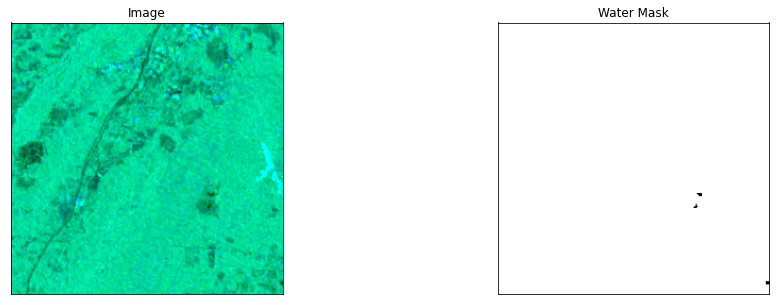

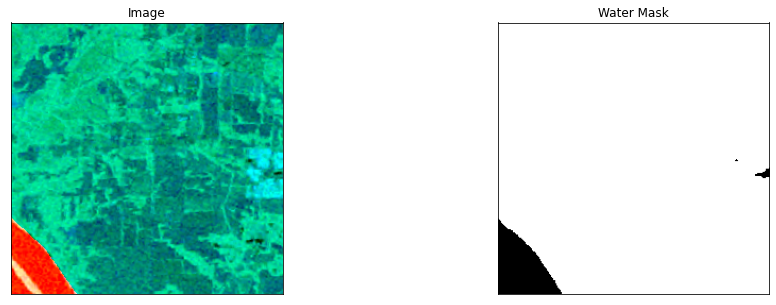

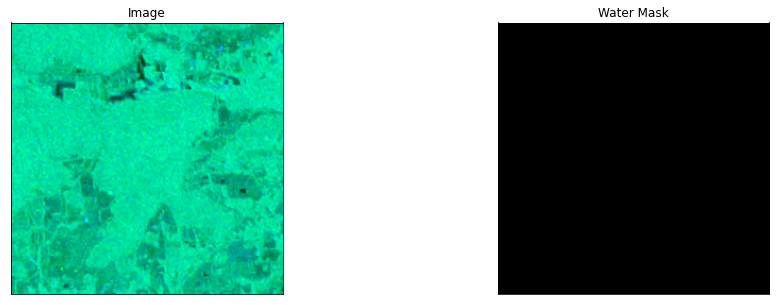

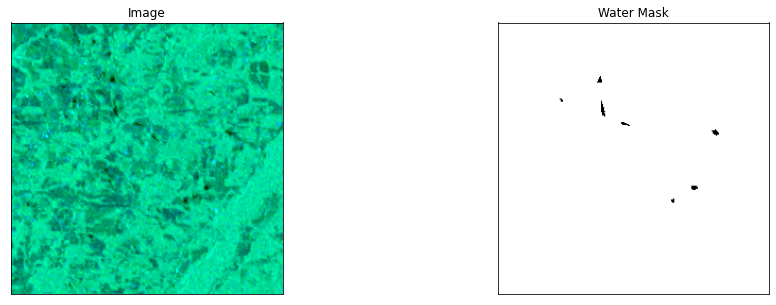

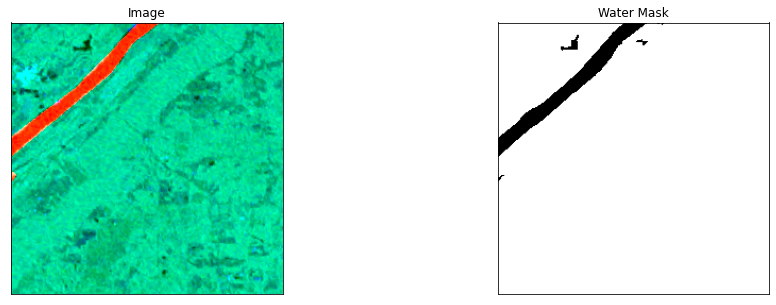

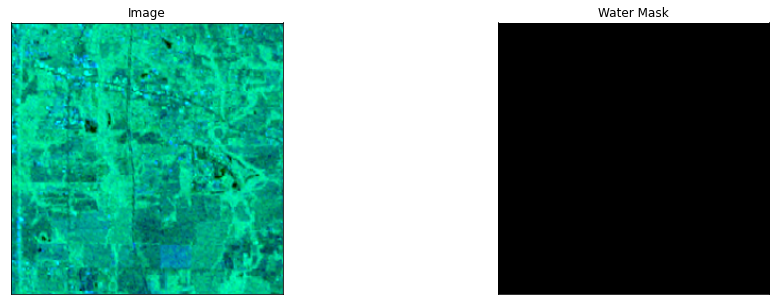

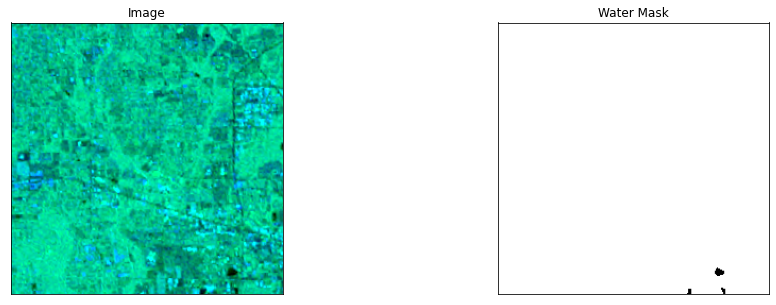

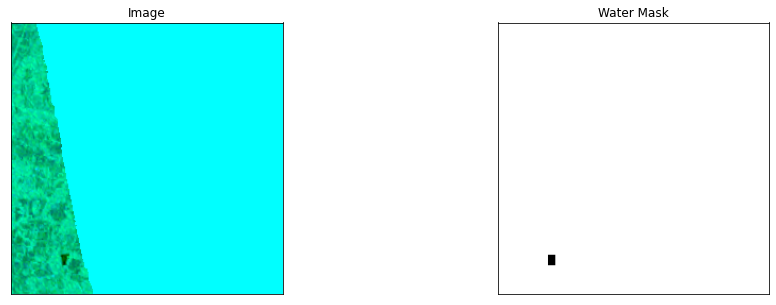

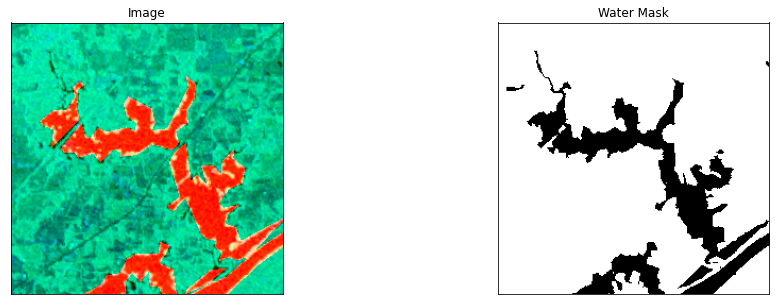

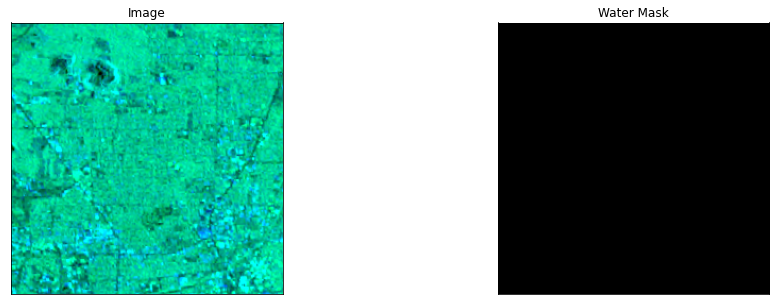

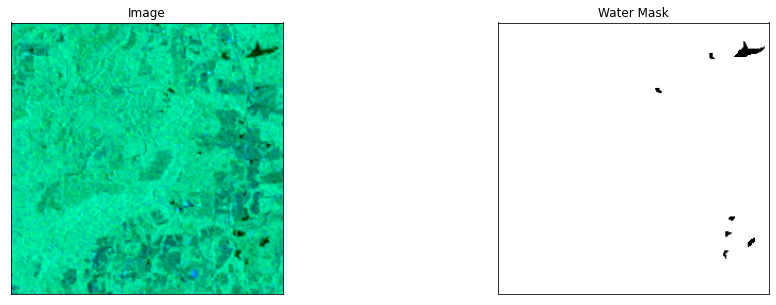

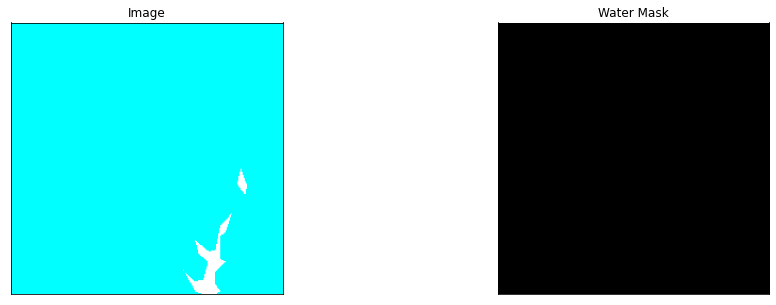

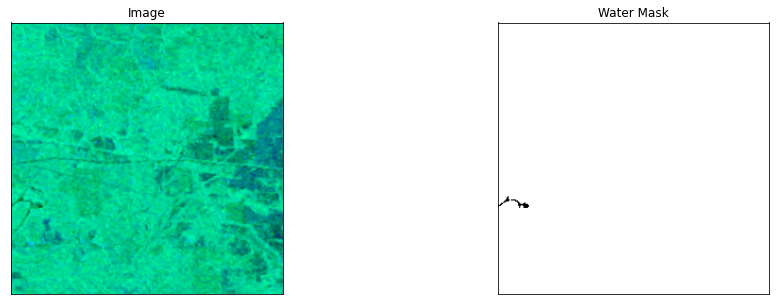

In [13]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['0','255'])

for i in range(0,28):
    
    image, mask = dataset[i] # get some sample
    visualize(
        image=image, 
        water_mask=mask[..., 0].squeeze(),
)

In [15]:
#%%
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 10
CLASSES = ['255']
LR = 0.0001
EPOCHS = 5

preprocess_input = sm.get_preprocessing(BACKBONE)



# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)


# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)


In [16]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

#train_dataset = train_dataset[0:3000]
#valid_dataset = valid_dataset[0:3000]

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [17]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 3000 steps
Epoch 1/5
  3/300 [..............................] - ETA: 1:10:15 - loss: 1.2579 - iou_score: 2.4947e-11 - f1-score: 2.4947e-11

KeyboardInterrupt: ignored

In [ ]:
SIZE_X = 128
SIZE_Y = 128
n_class=4

In [ ]:
# SIZE_X = 128
# SIZE_Y = 128
# n_class=4
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_data_for_ML')
# train_images=[]
# for directory_path in glob.glob("full_labels_for_deep_learning/128_patches/images*"):
#   for img_path in glob.glob(os.path.join(directory_path,"*.tif")):
#     img =cv2.imread(img_path,1)
#     train_images.append(img)

# train_images=[]
# train_masks=[]
# from skimage import io
# train_images = io.imread('full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif')
# train_masks = io.imread('full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif')
# print(train_images.shape)
# print(train_masks.shape)

# #Converting into numpy arrays 
# train_images = np.array(train_images)
# train_masks = np.array(train_masks)
# print(train_images.shape)
# print(train_masks.shape)

# # plt.imshow(train_images[3])
# # plt.imshow(train_masks[3])
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(train_masks[1])
# axarr[0].set_title('Mask')
# axarr[1].imshow(train_images[1])
# axarr[1].set_title('Image')

# # Checking the unique values in the masks 
# np.unique(train_masks)

# # Lets change the labels and make sure it starts from zero 
# # So we rearrange the pixels in a vector and then apply label encoder followed by reshaping again 
# from sklearn.preprocessing import LabelEncoder 
# labelencoder = LabelEncoder()
# n,h,w = train_masks.shape
# train_masks_reshaped = train_masks.reshape(-1,1)
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# train_masks_reshaped_encoded_origshape = train_masks_reshaped_encoded.reshape(n,h,w)
# print(np.unique(train_masks_reshaped_encoded_origshape))
# print(train_masks_reshaped_encoded_origshape.shape)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/sandstone_data_for_ML

sandstone_data_for_ML


In [ ]:
os.chdir('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_data_for_ML')

In [ ]:

train_images=[]

In [ ]:
for directory_path in glob.glob("full_labels_for_deep_learning/128_patches/images*"):
  for img_path in glob.glob(os.path.join(directory_path,"*.tif")):
    img =cv2.imread(img_path,1)
    train_images.append(img)


In [ ]:
glob.glob("full_labels_for_deep_learning/[12]*")

['full_labels_for_deep_learning/128_patches']

In [ ]:
directory_path = glob.glob("full_labels_for_deep_learning/128_patches/images/")

In [ ]:
# z = np.zeros(1600,28,28)
# for i in range(1600):
#     filename = './images_stone/img%i.tif' % i
#     img = cv2.imread(filename, 0)
#     z[i,:,:] = img[:,:]
# train_images = z

In [ ]:
glob.glob("full_labels_for_deep_learning/128_patches/images*")

['full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif']

while importing files with cv2,we encountered some issues.

In [ ]:
# train_images = cv2.imread('full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif',0)
# train_masks = cv2.imread('full_labels_for_deep_learning/128_patches/masks_as_128x128_patches',0)
# print(train_images.shape)
# print(train_masks.shape)

In [ ]:
train_images=[]
train_masks=[]
from skimage import io
train_images = io.imread('full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif')
train_masks = io.imread('full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif')
print(train_images.shape)
print(train_masks.shape)


(1600, 128, 128)
(1600, 128, 128)


In [ ]:
#Converting into numpy arrays 
train_images = np.array(train_images)
train_masks = np.array(train_masks)
print(train_images.shape)
print(train_masks.shape)

(1600, 128, 128)
(1600, 128, 128)


Text(0.5, 1.0, 'Image')

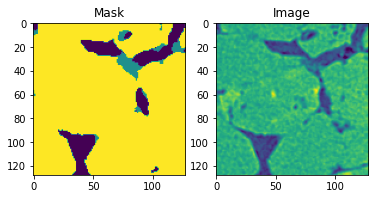

In [ ]:
# plt.imshow(train_images[3])
# plt.imshow(train_masks[3])
f, axarr = plt.subplots(1,2)
axarr[0].imshow(train_masks[1])
axarr[0].set_title('Mask')
axarr[1].imshow(train_images[1])
axarr[1].set_title('Image')


In [ ]:
# Checking the unique values in the masks 
np.unique(train_masks)

array([1, 2, 3, 4], dtype=uint8)

In [ ]:
# Lets change the labels and make sure it starts from zero 
# So we rearrange the pixels in a vector and then apply label encoder followed by reshaping again 
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder()
n,h,w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_reshaped_encoded_origshape = train_masks_reshaped_encoded.reshape(n,h,w)
print(np.unique(train_masks_reshaped_encoded_origshape))
print(train_masks_reshaped_encoded_origshape.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]
(1600, 128, 128)


 Looks Good 


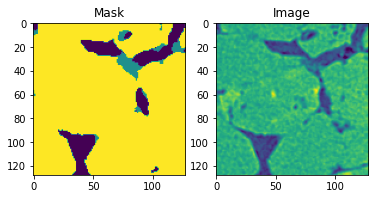

In [ ]:
# Plotting and checking if everything is good 
f, axarr = plt.subplots(1,2)
axarr[0].imshow(train_masks_reshaped_encoded_origshape[1])
axarr[0].set_title('Mask')
axarr[1].imshow(train_images[1])
axarr[1].set_title('Image')
print (" Looks Good ")

In [ ]:
# Its good to play with RGB images so add one more dimension (3 for training and 1 for mask) 
train_images_input = np.expand_dims(train_images, axis = 3)
train_masks_input = np.expand_dims(train_masks_reshaped_encoded_origshape, axis = 3)
train_images_input.shape
# The dimension of train_images_input must be (1600,128,128,3)however its not the same
#lets see work with greyscale image (without adding 1  )

(1600, 128, 128, 1)

In [ ]:
# Testing and Training split 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_images,train_masks_reshaped_encoded_origshape,
                                                    test_size = 0.10,
                                                    random_state = 0 
                                                    )
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1440, 128, 128)
(160, 128, 128)
(1440, 128, 128)
(160, 128, 128)


In [ ]:
# Further splitting train data for quick testimg 
x_train, x_donotuse, y_train, y_donotuse = train_test_split(x_train,y_train,
                                                    test_size = 0.5,
                                                    random_state = 0 
                                                    )
print(x_train.shape)
print(x_donotuse.shape)
print(y_train.shape)
print(y_donotuse.shape)

(720, 128, 128)
(720, 128, 128)
(720, 128, 128)
(720, 128, 128)


In [ ]:
# https://www.youtube.com/watch?v=F365vQ8EndQ [20:00]
# One hot encoding 
#import tensorflow as tf
from keras.utils.np_utils import to_categorical
n_classes=4
train_masks_cat = to_categorical(y_train, num_classes= n_classes)
y_train_Cat = train_masks_cat.reshape((y_train.shape[0],y_train.shape[1],y_train.shape[2],n_classes))

test_masks_cat = to_categorical(y_test, num_classes= n_classes)
y_test_Cat = test_masks_cat.reshape((y_test.shape[0],y_test.shape[1],y_test.shape[2],n_classes))

print(y_train_Cat.shape)
print(y_test_Cat.shape)


(720, 128, 128, 4)
(160, 128, 128, 4)


In [ ]:
activation = 'softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)
total_loss = sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



In [ ]:
#Model-1 
backbone_resnet = 'resnet34'
preprocess_input1= sm.get_preprocessing(backbone_resnet)
x_train1 = preprocess_input1(x_train)
x_test1 = preprocess_input1(x_test)

#model1 = sm.Unet(backbone_name= backbone_resnet, encoder_weights='imagenet',class=n_classes, activation=activation)
model1 = sm.Unet()
model1 = sm.Unet('resnet34', encoder_weights='imagenet')
#model1 = sm.Unet(backbone_resnet, encoder_weights='imagenet', classes=n_classes, activation=activation)

model1.compile(optim,total_loss,metrics=metrics)
print(model1.summary())



AttributeError: ignored

In [ ]:

history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

In [ ]:
import segmentation_models as sm
sm.Unet()

AttributeError: ignored